# Zadanie 5


Celem ćwiczenia jest implementacja perceptronu wielowarstwowego oraz wybranego algorytmu optymalizacji gradientowej z algorytmem propagacji wstecznej.

Następnie należy wytrenować perceptron wielowarstwowy do klasyfikacji zbioru danych [MNIST](http://yann.lecun.com/exdb/mnist/). Zbiór MNIST dostępny jest w pakiecie `scikit-learn`.

Punktacja:
1. Implementacja propagacji do przodu (`forward`) [1 pkt]
2. Implementacja wstecznej propagacji (zademonstrowana na bramce XOR) (`backward`) [2 pkt]
3. Przeprowadzenie eksperymentów na zbiorze MNIST, w tym:
    1. Porównanie co najmniej dwóch architektur sieci [1 pkt]
    2. Przetestowanie każdej architektury na conajmniej 3 ziarnach [1 pkt]
    3. Wnioski 1.[5 pkt]
4. Jakość kodu 0.[5 pkt]

Polecane źródła - teoria + intuicja:
1. [Karpathy, CS231n Winter 2016: Lecture 4: Backpropagation, Neural Networks 1](https://www.youtube.com/watch?v=i94OvYb6noo&ab_channel=AndrejKarpathy)
2. [3 Blude one Brown, Backpropagation calculus | Chapter 4, Deep learning
](https://www.youtube.com/watch?v=tIeHLnjs5U8&t=4s&ab_channel=3Blue1Brown)


In [168]:
from abc import abstractmethod, ABC
from typing import List
import numpy as np
from keras.utils import to_categorical
from keras.datasets import mnist
import matplotlib.pyplot as plt



In [169]:
class Layer(ABC):
    """Basic building block of the Neural Network"""

    def __init__(self) -> None:
        self._learning_rate = 0.1

    @abstractmethod
    def forward(self, x:np.ndarray)->np.ndarray:
        """Forward propagation of x through layer"""
        raise NotImplementedError

    @abstractmethod
    def backward(self, output_error_derivative) ->np.ndarray:
        """Backward propagation of output_error_derivative through layer"""
        raise NotImplementedError

    @property
    def learning_rate(self):
        return self._learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        assert learning_rate < 1, f"Given learning_rate={learning_rate} is larger than 1"
        assert learning_rate > 0, f"Given learning_rate={learning_rate} is smaller than 0"
        self._learning_rate = learning_rate

class FullyConnected(Layer):
    def __init__(self, input_size:int, output_size:int) -> None:
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.rand(self.input_size, self.output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

    def forward(self, x:np.ndarray)->np.ndarray:
        self.input = x
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    def backward(self, output_error_derivative, learning_rate)->np.ndarray:
        self.learning_rate = learning_rate
        input_error = np.dot(output_error_derivative, self.weights.T)
        weights_error = np.dot(self.input.T, output_error_derivative)
        self.weights -= self.learning_rate * weights_error
        self.bias -= self.learning_rate * output_error_derivative
        return input_error

class Tanh(Layer):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x:np.ndarray)->np.ndarray:
        self.input = x
        output = np.tanh(self.input)
        return output

    def backward(self, output_error_derivative, learning_rate)->np.ndarray:
        return output_error_derivative*(1-np.tanh(self.input)**2)

class Loss:
    def __init__(self, loss_function:callable, loss_function_derivative:callable)->None:
        self.loss_function = loss_function
        self.loss_function_derivative = loss_function_derivative

    def loss(self, y_true:np.ndarray, y_pred:np.ndarray)->np.ndarray:
        """Loss function for a particular x"""
        return self.loss_function(y_true, y_pred)

    def loss_derivative(self, y_true:np.ndarray, y_pred:np.ndarray)->np.ndarray:
        """Loss function derivative for a particular x and y"""
        return self.loss_function_derivative(y_true, y_pred)

class Network:
    def __init__(self, layers:List[Layer], learning_rate:float)->None:
        self.layers = layers
        self.learning_rate = learning_rate
        self.loss = None

    def compile(self, loss:Loss)->None:
        """Define the loss function and loss function derivative"""
        self.loss = Loss

    def __call__(self, x:np.ndarray) -> np.ndarray:
        """Forward propagation of x through all layers"""
        results = []
        for data in x:
          output = data
          for layer in self.layers:
            output = layer.forward(output)
          results.append(output)
        return results

    def fit(self,
            x_train:np.ndarray,
            y_train:np.ndarray,
            epochs:int,
            learning_rate:float,
            verbose:int=0)->None:
        """Fit the network to the training data"""
        num_of_samples = len(x_train)

        for epoch in range(epochs):
            err = 0
            for i in range(num_of_samples):

                #forward propagation
                output = x_train[i]
                for layer in self.layers:
                    output = layer.forward(output)
                err += calculate_error(y_train[i], output)

                #backward propagation
                error = calculate_error_derivative(y_train[i], output)
                for layer in reversed(self.layers):
                    error = layer.backward(error, learning_rate)
            err = err / num_of_samples
            print('epoch %d/%d   error=%f' % (epoch+1, epochs, err))
    
def calculate_error(y_true, y_pred):
        return np.mean(np.power(y_true-y_pred, 2))
        
def calculate_error_derivative(y_true, y_pred):
        return 2*(y_pred-y_true)/y_true.size
        





# Bramka XOR

In [170]:
X_train = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]]])
Y_train = np.array([[[0]], [[1]], [[1]], [[0]]])
layers = []
layers.append(FullyConnected(2,3))
layers.append(Tanh())
layers.append(FullyConnected(3,1))
layers.append(Tanh())
network = Network(layers, 0.1)
print("Niewytrenowana sieć")
print(network(X_train))
print("Trenowanie sieci")
network.fit(X_train, Y_train, 500, 0.1)
print("Wytrenowana sieć")
print(network(X_train))

Niewytrenowana sieć
[array([[-0.1465311]]), array([[-0.09460689]]), array([[-0.04513221]]), array([[0.0060104]])]
Trenowanie sieci
epoch 1/500   error=0.488634
epoch 2/500   error=0.326801
epoch 3/500   error=0.305130
epoch 4/500   error=0.299961
epoch 5/500   error=0.298001
epoch 6/500   error=0.296937
epoch 7/500   error=0.296195
epoch 8/500   error=0.295589
epoch 9/500   error=0.295049
epoch 10/500   error=0.294540
epoch 11/500   error=0.294046
epoch 12/500   error=0.293558
epoch 13/500   error=0.293068
epoch 14/500   error=0.292573
epoch 15/500   error=0.292068
epoch 16/500   error=0.291552
epoch 17/500   error=0.291021
epoch 18/500   error=0.290472
epoch 19/500   error=0.289905
epoch 20/500   error=0.289316
epoch 21/500   error=0.288704
epoch 22/500   error=0.288067
epoch 23/500   error=0.287404
epoch 24/500   error=0.286712
epoch 25/500   error=0.285990
epoch 26/500   error=0.285236
epoch 27/500   error=0.284449
epoch 28/500   error=0.283627
epoch 29/500   error=0.282769
epoch 30

Jak widać sieć bardzo dobrze działa dla przykładu bramki XOR. Do wytrenowania sieci wystarczyło zaledwie 500 epok.

# Eksperymenty MNIST
W doświadczeniam do trenowania używam pierwszego 1000 próbek (cały zestaw zawiera 60 000 cyfr - gdybym chciała przetrenować model dla ich wszystkich, musiałabym podzielić dane na pakiety (minibatch) i zastosować gradient stochastycznego spadku, co jest trudniejsze i bardziej pracochłonne w implementacji). Wyniki przedstawiam dla pierwszych dziesięciu cyfr ze zbioru testowego. Aby zwiększyć wiarygodność doświadczeń, program uruchamiam pięć razy dla każdego z modeli o liczbie warstw ukrytych od zera do trzech. Dla każdego modelu badam jakość klasyfikacji w zależności od współczynnika learning_rate o wartościach [0.01, 0.1, 0.25, 0.5]. Wszystkie doświadczenia przeprowadzam dla 20 epok.

In [171]:
def main(num_of_hidden, epochs, learning_rate):
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()

    # Convert y_train into one-hot format
    temp = []
    for i in range(len(Y_train)):
        temp.append(to_categorical(Y_train[i], num_classes=10))
    Y_train = np.array(temp)

    # Convert y_test into one-hot format
    temp = []
    for i in range(len(Y_test)):    
        temp.append(to_categorical(Y_test[i], num_classes=10))
    Y_test = np.array(temp)

    # Convert image into a vector
    image_vector_size = 28*28
    X_train = X_train.astype('float32')
    X_train = X_train / 255.0
    X_train = X_train.reshape(X_train.shape[0], 1, image_vector_size)
    X_test = X_test.astype('float32')
    X_test = X_test / 255.0
    X_test = X_test.reshape(X_test.shape[0], 1, image_vector_size)

    layers = []
    layers.append(FullyConnected(784, 28))
    layers.append(Tanh())
    for i in range(num_of_hidden):
      layers.append(FullyConnected(28, 28))
      layers.append(Tanh())
    layers.append(FullyConnected(28, 10))
    layers.append(Tanh())
    net = Network(layers, learning_rate)
    
    print("Niewytrenowana sieć")
    print("Wartości prawdziwe:")
    print(Y_test[0:10])
    print("Odpowiedź sieci:")
    print((np.argmax(net(X_test[0:10]), axis=2)).T)
    print("Trenowanie sieci")
    net.fit(X_train[0:1000], Y_train[0:1000], epochs, learning_rate)
    print("Wytrenowana sieć")
    predictions = net(X_test[0:10])
    predictions = np.argmax(predictions, axis=2)
    print(predictions.T)

    

    fig, axes = plt.subplots(ncols=10, sharex=False,
                         sharey=True, figsize=(20, 4))
    for i in range(10):
        axes[i].set_title(predictions[i])
        axes[i].imshow(X_test[i].reshape(28, 28), cmap='gray')
        axes[i].get_xaxis().set_visible(False)
        axes[i].get_yaxis().set_visible(False)
    plt.show()


** Brak warstw ukrytych **

Niewytrenowana sieć
Wartości prawdziwe:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Odpowiedź sieci:
[[7 7 7 7 6 7 5 7 5 0]]
Trenowanie sieci
epoch 1/20   error=0.365442
epoch 2/20   error=0.229780
epoch 3/20   error=0.154422
epoch 4/20   error=0.115234
epoch 5/20   error=0.095639
epoch 6/20   error=0.085029
epoch 7/20   error=0.078689
epoch 8/20   error=0.074572
epoch 9/20   error=0.071692
epoch 10/20   error=0.069538
epoch 11/20   error=0.067828
epoch 12/20   error=0.066403
epoch 13/20   error=0.065171
epoch 14/20   error=0.064076
epoch 15/20   error=0.063082
epoch 16/20   error=0.062167
epoch 17/20   error=0.061313
epoch 18/20   error=0.060509
epoch 19/20   error=0.059749
epoch 20/20   error=0.059026


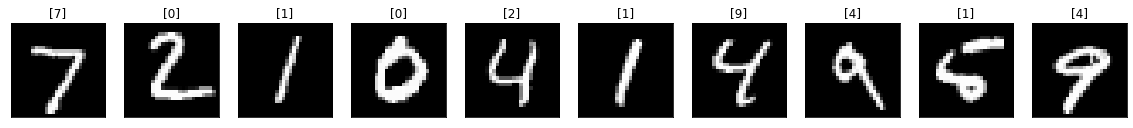

In [172]:
main(0, 20, 0.01)

Niewytrenowana sieć
Wartości prawdziwe:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Odpowiedź sieci:
[[3 5 5 9 6 5 3 9 3 5]]
Trenowanie sieci
epoch 1/20   error=0.166901
epoch 2/20   error=0.077823
epoch 3/20   error=0.067764
epoch 4/20   error=0.061919
epoch 5/20   error=0.057396
epoch 6/20   error=0.053646
epoch 7/20   error=0.050353
epoch 8/20   error=0.047630
epoch 9/20   error=0.045356
epoch 10/20   error=0.043287
epoch 11/20   error=0.041352
epoch 12/20   error=0.039587
epoch 13/20   error=0.037976
epoch 14/20   error=0.036560
epoch 15/20   error=0.035317
epoch 16/20   error=0.034209
epoch 17/20   error=0.033202
epoch 18/20   error=0.032264
epoch 19/20   error=0.031388
epoch 20/20   error=0.030571


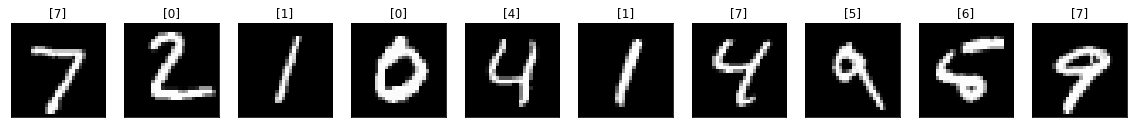

In [173]:
main(0, 20, 0.1)

Niewytrenowana sieć
Wartości prawdziwe:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Odpowiedź sieci:
[[0 1 1 1 2 1 2 2 2 2]]
Trenowanie sieci
epoch 1/20   error=0.166634
epoch 2/20   error=0.089650
epoch 3/20   error=0.072076
epoch 4/20   error=0.062139
epoch 5/20   error=0.055315
epoch 6/20   error=0.049917
epoch 7/20   error=0.045305
epoch 8/20   error=0.041212
epoch 9/20   error=0.037869
epoch 10/20   error=0.034842
epoch 11/20   error=0.031975
epoch 12/20   error=0.029476
epoch 13/20   error=0.027638
epoch 14/20   error=0.026027
epoch 15/20   error=0.024504
epoch 16/20   error=0.023138
epoch 17/20   error=0.022063
epoch 18/20   error=0.021185
epoch 19/20   error=0.020443
epoch 20/20   error=0.019867


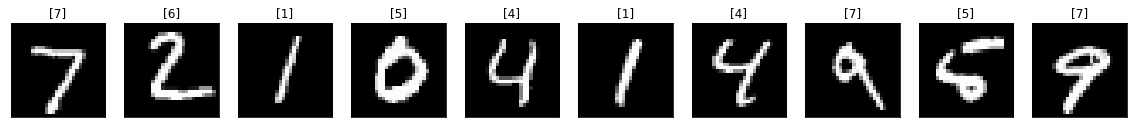

In [174]:
main(0, 20, 0.25)

Niewytrenowana sieć
Wartości prawdziwe:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Odpowiedź sieci:
[[6 6 6 6 6 0 6 2 5 6]]
Trenowanie sieci
epoch 1/20   error=0.294557
epoch 2/20   error=0.220361
epoch 3/20   error=0.200740
epoch 4/20   error=0.182994
epoch 5/20   error=0.172454
epoch 6/20   error=0.158570
epoch 7/20   error=0.144938
epoch 8/20   error=0.138255
epoch 9/20   error=0.135507
epoch 10/20   error=0.128156
epoch 11/20   error=0.134074
epoch 12/20   error=0.126447
epoch 13/20   error=0.116249
epoch 14/20   error=0.115636
epoch 15/20   error=0.110989
epoch 16/20   error=0.106088
epoch 17/20   error=0.104209
epoch 18/20   error=0.099145
epoch 19/20   error=0.103159
epoch 20/20   error=0.101766


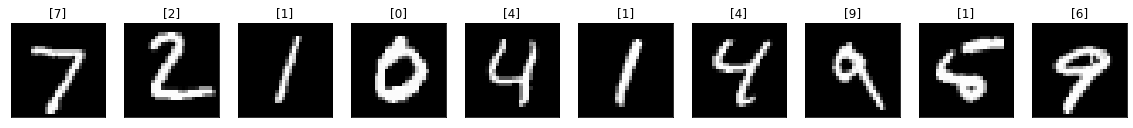

In [175]:
main(0, 20, 0.5)

Wartość learning_rate, dla jakiego uzyskano najmniejszą wartość błędu w kolejnych uruchomieniach programu:
1: 0.25;
2: 0.1;
3: 0.25;
4: 0.1;
5: 0.25.
Dla sieci bez warstwy ukrytej najmniejszą wartość błędu uzyskano zwykle dla wartości learning_rate = 0.25. dla wartości learning_rate=0.01 oraz learning_rate=0.5 sieć działa przeciętnie - współczynnik learning_rate wykorzystywany w metodzie gradientu prostego jest za mały dla tego modelu, zaś dla 0.5 za duży.

**Jedna warstwa ukryta**

Niewytrenowana sieć
Wartości prawdziwe:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Odpowiedź sieci:
[[9 4 2 9 6 9 2 4 8 4]]
Trenowanie sieci
epoch 1/20   error=0.264308
epoch 2/20   error=0.136427
epoch 3/20   error=0.103049
epoch 4/20   error=0.090487
epoch 5/20   error=0.083824
epoch 6/20   error=0.079497
epoch 7/20   error=0.076338
epoch 8/20   error=0.073852
epoch 9/20   error=0.071794
epoch 10/20   error=0.070028
epoch 11/20   error=0.068472
epoch 12/20   error=0.067076
epoch 13/20   error=0.065803
epoch 14/20   error=0.064628
epoch 15/20   error=0.063534
epoch 16/20   error=0.062506
epoch 17/20   error=0.061532
epoch 18/20   error=0.060604
epoch 19/20   error=0.059715
epoch 20/20   error=0.058860


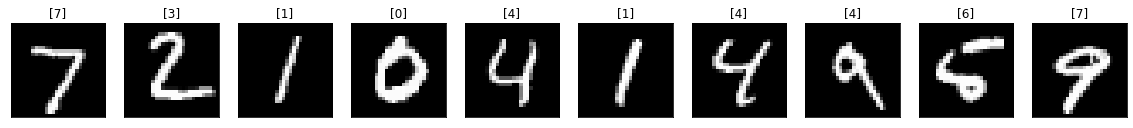

In [176]:
main(1, 20, 0.01)

Niewytrenowana sieć
Wartości prawdziwe:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Odpowiedź sieci:
[[7 7 1 9 4 2 7 6 2 7]]
Trenowanie sieci
epoch 1/20   error=0.131630
epoch 2/20   error=0.074698
epoch 3/20   error=0.062360
epoch 4/20   error=0.054257
epoch 5/20   error=0.048002
epoch 6/20   error=0.043075
epoch 7/20   error=0.039010
epoch 8/20   error=0.035519
epoch 9/20   error=0.032558
epoch 10/20   error=0.030092
epoch 11/20   error=0.028003
epoch 12/20   error=0.026159
epoch 13/20   error=0.024503
epoch 14/20   error=0.023004
epoch 15/20   error=0.021639
epoch 16/20   error=0.020380
epoch 17/20   error=0.019198
epoch 18/20   error=0.018095
epoch 19/20   error=0.017096
epoch 20/20   error=0.016216


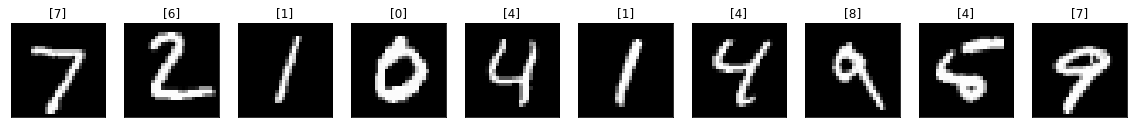

In [177]:
main(1, 20, 0.1)

Niewytrenowana sieć
Wartości prawdziwe:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Odpowiedź sieci:
[[0 6 6 6 3 0 4 4 0 0]]
Trenowanie sieci
epoch 1/20   error=0.137907
epoch 2/20   error=0.075195
epoch 3/20   error=0.057570
epoch 4/20   error=0.046393
epoch 5/20   error=0.038530
epoch 6/20   error=0.033100
epoch 7/20   error=0.028583
epoch 8/20   error=0.024808
epoch 9/20   error=0.021788
epoch 10/20   error=0.019452
epoch 11/20   error=0.017264
epoch 12/20   error=0.015457
epoch 13/20   error=0.013925
epoch 14/20   error=0.012700
epoch 15/20   error=0.011683
epoch 16/20   error=0.010823
epoch 17/20   error=0.010058
epoch 18/20   error=0.009361
epoch 19/20   error=0.008749
epoch 20/20   error=0.008041


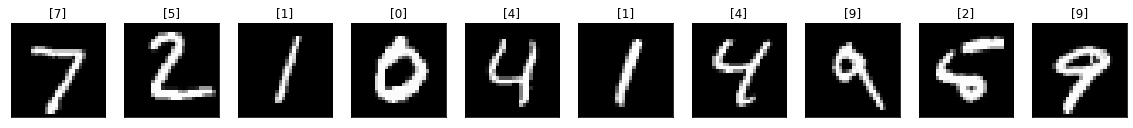

In [178]:
main(1, 20, 0.25)

Niewytrenowana sieć
Wartości prawdziwe:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Odpowiedź sieci:
[[4 6 6 3 4 6 9 0 6 0]]
Trenowanie sieci
epoch 1/20   error=0.176141
epoch 2/20   error=0.083002
epoch 3/20   error=0.063906
epoch 4/20   error=0.053677
epoch 5/20   error=0.046702
epoch 6/20   error=0.040755
epoch 7/20   error=0.036000
epoch 8/20   error=0.032543
epoch 9/20   error=0.029228
epoch 10/20   error=0.027458
epoch 11/20   error=0.025456
epoch 12/20   error=0.023420
epoch 13/20   error=0.022416
epoch 14/20   error=0.021076
epoch 15/20   error=0.019899
epoch 16/20   error=0.018887
epoch 17/20   error=0.017563
epoch 18/20   error=0.016619
epoch 19/20   error=0.016368
epoch 20/20   error=0.015172


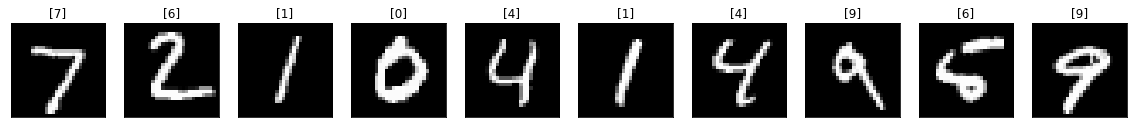

In [179]:
main(1, 20, 0.5)

Wartość learning_rate, dla jakiego uzyskano najmniejszą wartość błędu w kolejnych uruchomieniach programu:
1: 0.25;
2: 0.25;
3: 0.5;
4: 0.25;
5: 0.25.
Dla sieci o jednej warstwie ukrytej najmniejszy błąd osiągamy najczęściej dla wartości współczynnika learning_rate = 0.25 

**Dwie warstwy ukryte**

Niewytrenowana sieć
Wartości prawdziwe:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Odpowiedź sieci:
[[2 2 1 9 3 6 3 6 2 2]]
Trenowanie sieci
epoch 1/20   error=0.209462
epoch 2/20   error=0.110460
epoch 3/20   error=0.090115
epoch 4/20   error=0.081230
epoch 5/20   error=0.075850
epoch 6/20   error=0.072024
epoch 7/20   error=0.069057
epoch 8/20   error=0.066625
epoch 9/20   error=0.064554
epoch 10/20   error=0.062742
epoch 11/20   error=0.061122
epoch 12/20   error=0.059651
epoch 13/20   error=0.058297
epoch 14/20   error=0.057040
epoch 15/20   error=0.055862
epoch 16/20   error=0.054751
epoch 17/20   error=0.053701
epoch 18/20   error=0.052703
epoch 19/20   error=0.051752
epoch 20/20   error=0.050844


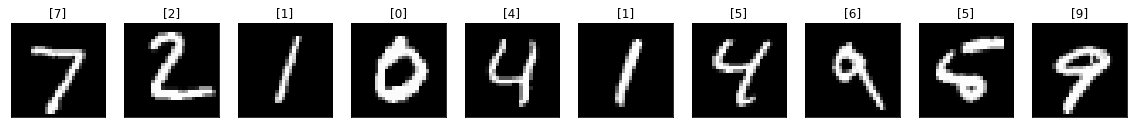

In [180]:
main(2, 20, 0.01)

Niewytrenowana sieć
Wartości prawdziwe:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Odpowiedź sieci:
[[3 3 3 5 3 3 3 3 3 3]]
Trenowanie sieci
epoch 1/20   error=0.125605
epoch 2/20   error=0.078474
epoch 3/20   error=0.063532
epoch 4/20   error=0.054066
epoch 5/20   error=0.047044
epoch 6/20   error=0.041421
epoch 7/20   error=0.036889
epoch 8/20   error=0.033140
epoch 9/20   error=0.029890
epoch 10/20   error=0.027014
epoch 11/20   error=0.024482
epoch 12/20   error=0.022292
epoch 13/20   error=0.020363
epoch 14/20   error=0.018628
epoch 15/20   error=0.017081
epoch 16/20   error=0.015706
epoch 17/20   error=0.014495
epoch 18/20   error=0.013442
epoch 19/20   error=0.012521
epoch 20/20   error=0.011705


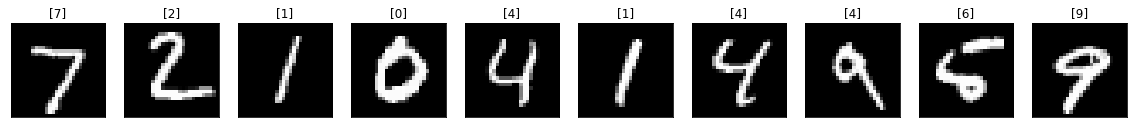

In [181]:
main(2, 20, 0.1)

Niewytrenowana sieć
Wartości prawdziwe:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Odpowiedź sieci:
[[6 2 4 6 6 4 9 4 9 3]]
Trenowanie sieci
epoch 1/20   error=0.138854
epoch 2/20   error=0.077091
epoch 3/20   error=0.056517
epoch 4/20   error=0.044902
epoch 5/20   error=0.037324
epoch 6/20   error=0.031892
epoch 7/20   error=0.027299
epoch 8/20   error=0.023320
epoch 9/20   error=0.020189
epoch 10/20   error=0.017515
epoch 11/20   error=0.015447
epoch 12/20   error=0.013594
epoch 13/20   error=0.012093
epoch 14/20   error=0.010747
epoch 15/20   error=0.009931
epoch 16/20   error=0.009236
epoch 17/20   error=0.008576
epoch 18/20   error=0.007735
epoch 19/20   error=0.006742
epoch 20/20   error=0.005989


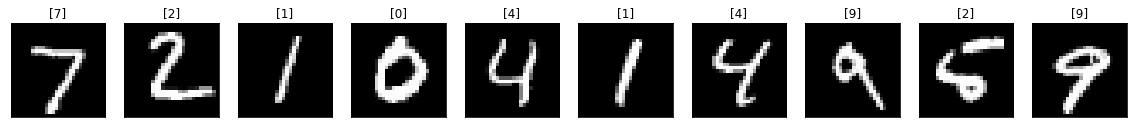

In [182]:
main(2, 20, 0.25)

Niewytrenowana sieć
Wartości prawdziwe:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Odpowiedź sieci:
[[8 3 8 3 6 4 8 4 6 8]]
Trenowanie sieci
epoch 1/20   error=0.134907
epoch 2/20   error=0.060387
epoch 3/20   error=0.045958
epoch 4/20   error=0.036063
epoch 5/20   error=0.029541
epoch 6/20   error=0.024417
epoch 7/20   error=0.020252
epoch 8/20   error=0.017052
epoch 9/20   error=0.014674
epoch 10/20   error=0.013003
epoch 11/20   error=0.011765
epoch 12/20   error=0.010504
epoch 13/20   error=0.009294
epoch 14/20   error=0.008296
epoch 15/20   error=0.007647
epoch 16/20   error=0.007034
epoch 17/20   error=0.007528
epoch 18/20   error=0.006549
epoch 19/20   error=0.005540
epoch 20/20   error=0.004782


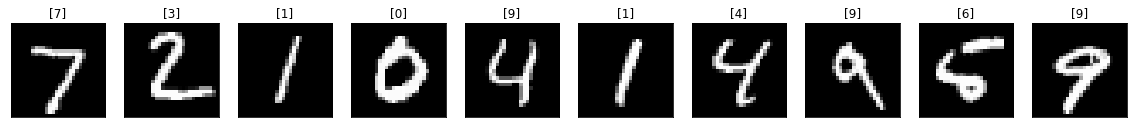

In [183]:
main(2, 20, 0.5)

Wartość learning_rate, dla jakiego uzyskano najmniejszą wartość błędu w kolejnych uruchomieniach programu:
1: 0.5;
2: 0.5;
3: 0.5;
4: 0.5;
5: 0.5.
Dla sieci o dwóch warstwach ukrytych we wszystkich pięciu doświadczeniach najlepszy wynik uzyskano dla współczynnika learning_rate = 0.5

**Trzy warstwy ukryte**

Niewytrenowana sieć
Wartości prawdziwe:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Odpowiedź sieci:
[[9 2 1 2 0 0 9 2 2 9]]
Trenowanie sieci
epoch 1/20   error=0.199555
epoch 2/20   error=0.099067
epoch 3/20   error=0.086976
epoch 4/20   error=0.081799
epoch 5/20   error=0.078247
epoch 6/20   error=0.075403
epoch 7/20   error=0.072972
epoch 8/20   error=0.070813
epoch 9/20   error=0.068854
epoch 10/20   error=0.067058
epoch 11/20   error=0.065405
epoch 12/20   error=0.063880
epoch 13/20   error=0.062467
epoch 14/20   error=0.061148
epoch 15/20   error=0.059908
epoch 16/20   error=0.058733
epoch 17/20   error=0.057614
epoch 18/20   error=0.056543
epoch 19/20   error=0.055515
epoch 20/20   error=0.054527


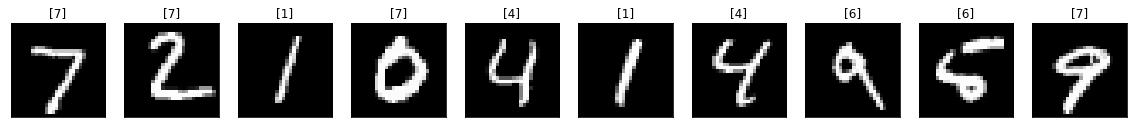

In [184]:
main(3, 20, 0.01)

Niewytrenowana sieć
Wartości prawdziwe:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Odpowiedź sieci:
[[7 2 5 1 7 5 5 1 3 1]]
Trenowanie sieci
epoch 1/20   error=0.115810
epoch 2/20   error=0.079560
epoch 3/20   error=0.066121
epoch 4/20   error=0.056846
epoch 5/20   error=0.049588
epoch 6/20   error=0.043950
epoch 7/20   error=0.039128
epoch 8/20   error=0.034799
epoch 9/20   error=0.030984
epoch 10/20   error=0.027619
epoch 11/20   error=0.024597
epoch 12/20   error=0.021896
epoch 13/20   error=0.019471
epoch 14/20   error=0.017163
epoch 15/20   error=0.015134
epoch 16/20   error=0.013483
epoch 17/20   error=0.012047
epoch 18/20   error=0.010893
epoch 19/20   error=0.009927
epoch 20/20   error=0.009085


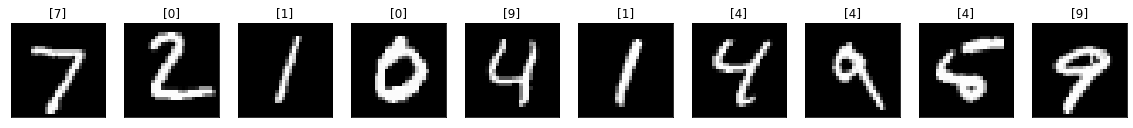

In [185]:
main(3, 20, 0.1)

Niewytrenowana sieć
Wartości prawdziwe:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Odpowiedź sieci:
[[3 9 5 3 3 5 3 3 3 3]]
Trenowanie sieci
epoch 1/20   error=0.143909
epoch 2/20   error=0.072042
epoch 3/20   error=0.051974
epoch 4/20   error=0.039490
epoch 5/20   error=0.030040
epoch 6/20   error=0.023548
epoch 7/20   error=0.019506
epoch 8/20   error=0.016300
epoch 9/20   error=0.013873
epoch 10/20   error=0.012024
epoch 11/20   error=0.010489
epoch 12/20   error=0.009300
epoch 13/20   error=0.008147
epoch 14/20   error=0.007424
epoch 15/20   error=0.006579
epoch 16/20   error=0.005996
epoch 17/20   error=0.005361
epoch 18/20   error=0.004896
epoch 19/20   error=0.004202
epoch 20/20   error=0.003812


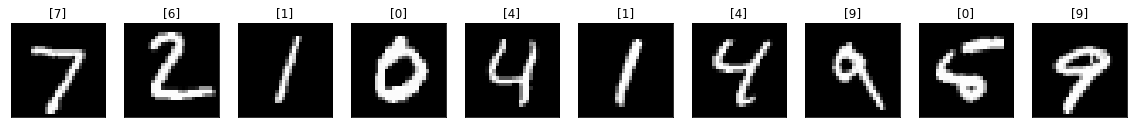

In [186]:
main(3, 20, 0.25)

Niewytrenowana sieć
Wartości prawdziwe:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Odpowiedź sieci:
[[1 1 5 3 3 1 3 1 3 1]]
Trenowanie sieci
epoch 1/20   error=0.174351
epoch 2/20   error=0.070184
epoch 3/20   error=0.049100
epoch 4/20   error=0.039642
epoch 5/20   error=0.030450
epoch 6/20   error=0.025540
epoch 7/20   error=0.021182
epoch 8/20   error=0.019520
epoch 9/20   error=0.016194
epoch 10/20   error=0.014600
epoch 11/20   error=0.012532
epoch 12/20   error=0.010690
epoch 13/20   error=0.009413
epoch 14/20   error=0.009885
epoch 15/20   error=0.013196
epoch 16/20   error=0.009929
epoch 17/20   error=0.014230
epoch 18/20   error=0.012143
epoch 19/20   error=0.009077
epoch 20/20   error=0.009622


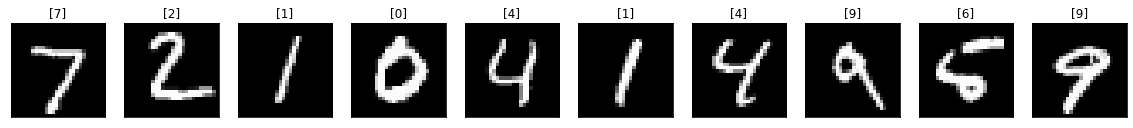

In [187]:
main(3, 20, 0.5)

Wartość learning_rate, dla jakiego uzyskano najmniejszą wartość błędu w kolejnych uruchomieniach programu:
1: 0.5;
2: 0.25;
3: 0.25;
4: 0.25;
5: 0.25.
Dla trzech warstw ukrytych najlepszy wynik zwykle uzyskiwano dla learning_rate=0.25.

# Wnioski

Sieci neuronowe są dobrym klasyfikatorem. Stworzony przeze mnie model działa dobrze (niskie wartości błędów), ale nie rozpoznaje jednocześnie wszystkich dziesięciu cyfr z obrazków. Dla większej liczby warstw ukrytych uzyskiwałam mniejsze wartości błędu. Dla konkretnych modeli różne wartości współczynnika learning_rate były optymalne. 